## Image Classification with Pytorch

In [122]:
import os
import json
from collections import defaultdict
from tqdm import tqdm
import pickle
from time import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from itertools import chain

import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, datasets
from torchsummary import summary
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from skimage.io import imread
from torch.autograd import Variable
from torch.optim import Adam, SGD
from sklearn.metrics import accuracy_score
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

In [123]:
root_captioning = "../s3"

In [124]:
def get_img_info(name, num=np.inf):
    """
    Returns img paths and captions

    Parameters:
    -----------
    name: str
        the json file name
    num: int (default: np.inf)
        the number of observations to get

    Return:
    --------
    list, dict, int
        img paths, corresponding captions, max length of captions
    """
    img_path = []
    caption = [] 
    max_length = 0
    with open(f'{root_captioning}/json/{name}.json', 'r') as json_data:
        data = json.load(json_data)
        for filename in data.keys():
            if num is not None and len(caption) == num:
                break
            img_path.append(
                f'{root_captioning}/{name}/{filename}'
            )
            sen_list = []
            for sentence in data[filename]['sentences']:
                max_length = max(max_length, len(sentence['tokens']))
                sen_list.append(sentence['raw'])

            caption.append(sen_list)
    
    return img_path, caption, max_length            


In [125]:
train_paths, train_descriptions, max_length_train = get_img_info('train')
test_paths, test_descriptions, max_length_test = get_img_info('valid')

In [126]:
class_train_paths = []
class_train_classes = []
for i in range(0, len(train_paths)):
    matches = re.findall("rsicd_[a-z]+", train_paths[i])
    if len(matches) == 1:
        class_train_classes.append(matches[0][6:])
        class_train_paths.append(train_paths[i])

In [127]:
class_train_paths_test = []
class_train_classes_test = []
for i in range(0, len(test_paths)):
    matches = re.findall("rsicd_[a-z]+", test_paths[i])
    if len(matches) == 1:
        class_train_classes_test.append(matches[0][6:])
        class_train_paths_test.append(test_paths[i])

In [128]:
print(len(class_train_classes))
print(len(set(class_train_classes)))

6384
30


In [129]:
labels = set(class_train_classes)
labels

{'airport',
 'bareland',
 'baseballfield',
 'beach',
 'bridge',
 'center',
 'church',
 'commercial',
 'denseresidential',
 'desert',
 'farmland',
 'forest',
 'industrial',
 'meadow',
 'mediumresidential',
 'mountain',
 'park',
 'parking',
 'playground',
 'pond',
 'port',
 'railwaystation',
 'resort',
 'river',
 'school',
 'sparseresidential',
 'square',
 'stadium',
 'storagetanks',
 'viaduct'}

In [130]:
d = dict()
i = 0
for label in labels:
    if label not in d:
        d[label] = i
        i += 1
print(d)

{'parking': 0, 'airport': 1, 'square': 2, 'river': 3, 'school': 4, 'center': 5, 'desert': 6, 'mediumresidential': 7, 'denseresidential': 8, 'forest': 9, 'beach': 10, 'church': 11, 'farmland': 12, 'park': 13, 'playground': 14, 'viaduct': 15, 'bridge': 16, 'railwaystation': 17, 'mountain': 18, 'meadow': 19, 'bareland': 20, 'baseballfield': 21, 'resort': 22, 'commercial': 23, 'storagetanks': 24, 'pond': 25, 'industrial': 26, 'port': 27, 'stadium': 28, 'sparseresidential': 29}


In [131]:
train_img = []
train_y = []
train_length = 100
for i in range(0, train_length):
    # defining the image path
    image_path = class_train_paths[i]
    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)
    train_y.append(class_train_classes[i])
    
# converting the list to numpy array
train_x = np.array(train_img)
# defining the target
train_x.shape
train_y = np.array(train_y)
for i in range(0, len(train_y)):
    train_y[i] = d[train_y[i]]
train_y

array(['8', '22', '21', '9', '2', '24', '0', '4', '20', '8', '22', '25',
       '29', '19', '6', '21', '28', '16', '5', '18', '21', '10', '26',
       '13', '10', '29', '24', '16', '1', '26', '10', '12', '2', '6',
       '21', '10', '27', '20', '9', '5', '3', '0', '0', '7', '16', '4',
       '22', '10', '2', '22', '8', '2', '25', '28', '18', '23', '14', '8',
       '6', '13', '4', '25', '25', '13', '14', '26', '18', '3', '23', '6',
       '22', '14', '17', '29', '25', '5', '11', '19', '3', '25', '8', '5',
       '26', '7', '13', '27', '18', '14', '18', '29', '7', '27', '23',
       '9', '18', '26', '10', '17', '12', '24'], dtype='<U17')

In [132]:
test_img = []
test_y = []
test_length = 50
for i in range(0, test_length):
    # defining the image path
    image_path = class_train_paths_test[i]
    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    test_img.append(img)
    test_y.append(class_train_classes_test[i])
    
# converting the list to numpy array
test_x = np.array(test_img)
# defining the target
test_x.shape
test_y = np.array(test_y)
for i in range(0, len(test_y)):
    test_y[i] = d[test_y[i]]
test_y

array(['13', '18', '8', '4', '26', '23', '19', '25', '11', '14', '20',
       '12', '19', '8', '22', '5', '8', '23', '4', '23', '9', '20', '16',
       '25', '20', '3', '27', '17', '9', '9', '20', '29', '10', '13',
       '12', '14', '13', '27', '15', '25', '12', '0', '16', '3', '10',
       '12', '27', '17', '10', '3'], dtype='<U17')

In [133]:
test_img

[array([[0.00148622, 0.00117864, 0.00097872, ..., 0.0019188 , 0.00227356,
         0.00224059],
        [0.00157849, 0.00130167, 0.00110175, ..., 0.00176501, 0.00212529,
         0.00202307],
        [0.00165538, 0.00147084, 0.00122478, ..., 0.00146296, 0.00206378,
         0.00216921],
        ...,
        [0.00199217, 0.00208222, 0.00225585, ..., 0.00082721, 0.00142476,
         0.00198055],
        [0.00202739, 0.00204277, 0.00218118, ..., 0.00102386, 0.00159393,
         0.00212445],
        [0.00191869, 0.00191209, 0.00201974, ..., 0.00117765, 0.00171696,
         0.00220908]], dtype=float32),
 array([[0.00166271, 0.00150233, 0.00158687, ..., 0.00207689, 0.00186932,
         0.00166939],
        [0.00186368, 0.0018483 , 0.00194058, ..., 0.00172318, 0.00139258,
         0.00122341],
        [0.00198671, 0.00218663, 0.00223277, ..., 0.00127719, 0.00115416,
         0.00118492],
        ...,
        [0.00250512, 0.00248974, 0.00247215, ..., 0.00156087, 0.00137632,
         0.00127314

5


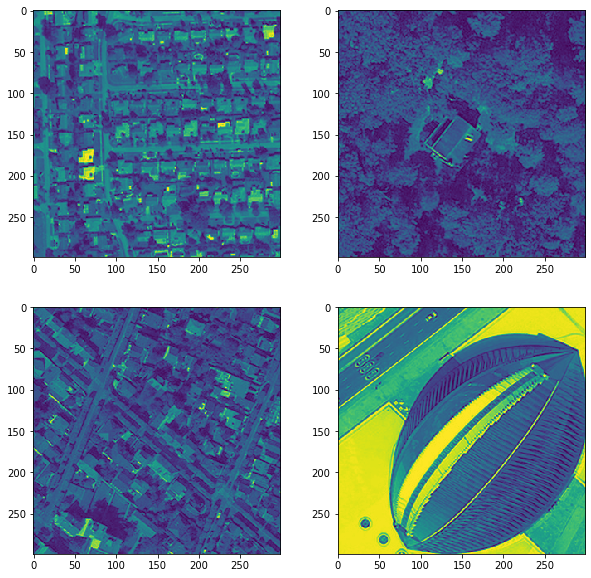

In [134]:
# visualizing images
i = 0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_x[i])
plt.subplot(222), plt.imshow(train_x[i+25])
plt.subplot(223), plt.imshow(train_x[i+50])
plt.subplot(224), plt.imshow(train_x[i+75])
print(train_y[i+75])

In [135]:
(train_x.shape, train_y.shape)

((100, 299, 299), (100,))

In [136]:
(test_x.shape, test_y.shape)

((50, 299, 299), (50,))

In [137]:
# converting training images into torch format
train_x = train_x.reshape(train_length, 1, 299, 299)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int);
print(train_y)
train_y = torch.from_numpy(train_y)
# shape of training data
train_x.shape, train_y.shape

[ 8 22 21  9  2 24  0  4 20  8 22 25 29 19  6 21 28 16  5 18 21 10 26 13
 10 29 24 16  1 26 10 12  2  6 21 10 27 20  9  5  3  0  0  7 16  4 22 10
  2 22  8  2 25 28 18 23 14  8  6 13  4 25 25 13 14 26 18  3 23  6 22 14
 17 29 25  5 11 19  3 25  8  5 26  7 13 27 18 14 18 29  7 27 23  9 18 26
 10 17 12 24]


(torch.Size([100, 1, 299, 299]), torch.Size([100]))

In [138]:
# converting training images into torch format
test_x = test_x.reshape(test_length, 1, 299, 299)
val_x  = torch.from_numpy(test_x)

# converting the target into torch format
test_y = test_y.astype(int);
val_y = torch.from_numpy(test_y)
# shape of training data
val_x.shape, val_y.shape

(torch.Size([50, 1, 299, 299]), torch.Size([50]))

In [139]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(21904, len(set(class_train_classes)))
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [140]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=21904, out_features=30, bias=True)
  )
)


In [141]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [142]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(3.5669, grad_fn=<NllLossBackward>)
Epoch :  3 	 loss : tensor(613.3337, grad_fn=<NllLossBackward>)
Epoch :  5 	 loss : tensor(456.7421, grad_fn=<NllLossBackward>)
Epoch :  7 	 loss : tensor(318.8360, grad_fn=<NllLossBackward>)
Epoch :  9 	 loss : tensor(143.0500, grad_fn=<NllLossBackward>)
Epoch :  11 	 loss : tensor(57.3117, grad_fn=<NllLossBackward>)
Epoch :  13 	 loss : tensor(13.1917, grad_fn=<NllLossBackward>)
Epoch :  15 	 loss : tensor(3.4210, grad_fn=<NllLossBackward>)
Epoch :  17 	 loss : tensor(3.4196, grad_fn=<NllLossBackward>)
Epoch :  19 	 loss : tensor(3.4181, grad_fn=<NllLossBackward>)
Epoch :  21 	 loss : tensor(3.4169, grad_fn=<NllLossBackward>)
Epoch :  23 	 loss : tensor(3.4169, grad_fn=<NllLossBackward>)
Epoch :  25 	 loss : tensor(3.4184, grad_fn=<NllLossBackward>)


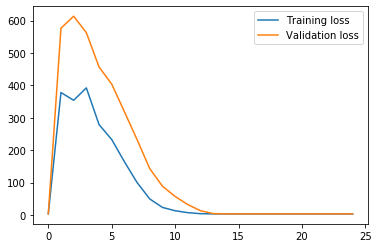

In [143]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [144]:
with torch.no_grad():
    output = model(train_x)
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
accuracy_score(train_y, predictions)

0.04

In [145]:
train_y

tensor([ 8, 22, 21,  9,  2, 24,  0,  4, 20,  8, 22, 25, 29, 19,  6, 21, 28, 16,
         5, 18, 21, 10, 26, 13, 10, 29, 24, 16,  1, 26, 10, 12,  2,  6, 21, 10,
        27, 20,  9,  5,  3,  0,  0,  7, 16,  4, 22, 10,  2, 22,  8,  2, 25, 28,
        18, 23, 14,  8,  6, 13,  4, 25, 25, 13, 14, 26, 18,  3, 23,  6, 22, 14,
        17, 29, 25,  5, 11, 19,  3, 25,  8,  5, 26,  7, 13, 27, 18, 14, 18, 29,
         7, 27, 23,  9, 18, 26, 10, 17, 12, 24])

In [146]:
predictions

array([21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21])